In [5]:
from openai import OpenAI
import os
from dotenv import load_dotenv

In [6]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise RuntimeError("Missing OpenAI API key. Set OPENAI_API_KEY in .env (or OPENAI_KEY for backward compatibility).")

# 1. How embedding works

## Single text input

In [13]:
# initialize the client
client = OpenAI(api_key=api_key)

# create embeddings request
response = client.embeddings.create(model="text-embedding-3-small",
                                    input="Embeddings are a numerical representation of text that can be used to measure the relatedness between two pieces of text.")

# Extract the response
response_dic = response.model_dump()
print(f"Number of embeddings: {len(response_dic['data'])}")
print(f"Embedding dimensions: {len(response_dic['data'][0]['embedding'])}\n")
print(response_dic['data'][0]['embedding'])

Number of embeddings: 1
Embedding dimensions: 1536

[-0.016230566427111626, -0.01696062460541725, 0.0343233086168766, 0.0007829607930034399, 0.01564863510429859, 0.008136443793773651, 0.06170577555894852, -0.021446777507662773, -0.011035514995455742, 0.003380486276000738, -0.0009820074774324894, -0.005271759815514088, 1.603614873602055e-05, -0.03354034945368767, 0.041094861924648285, -0.0013066980754956603, 0.02577422372996807, -0.004639571998268366, 0.02026175707578659, 0.06576871126890182, 0.013553686439990997, -0.011606864631175995, 0.009009339846670628, 0.035931553691625595, 0.022853991016745567, 0.011363512836396694, 0.013077561743557453, 0.03808998689055443, 0.057219624519348145, -0.03961358591914177, -0.023044440895318985, -0.013797039166092873, 0.02535100094974041, -0.009125725366175175, -0.007078389171510935, 0.03741282969713211, -0.031741656363010406, 0.03311712667346001, -0.014389550313353539, 0.025329841300845146, 0.011183642782270908, 0.050532713532447815, -0.0700432509183

## Multiple text inputs

In [19]:
articles = [
    {"headline": "Economic Growth Continues Amid Global Uncertainty", "topic": "Business"},
    {"headline": "Interest rates fall to historic lows", "topic": "Business"},
    {"headline": "Scientists Make Breakthrough Discovery in Renewable Energy", "topic": "Science"}]

# Extract headlines
headlines_text = [article['headline'] for article in articles]

# Generate embedding for each headline
response = client.embeddings.create(model="text-embedding-3-small",
                                    input=headlines_text)

# Extract the response
response_dic = response.model_dump()

# Assign embeddings to articles
print(f"Number of embeddings: {len(response_dic['data'])}")
for i, article in enumerate(articles):
    article['embedding'] = response_dic['data'][i]['embedding']
    print(f"Embedding {i} dimensions: {len(response_dic['data'][0]['embedding'])}")

# Print the last embedding
print('Last embedding:')
print(response_dic['data'][-1]['embedding'])


Number of embeddings: 3
Embedding 0 dimensions: 1536
Embedding 1 dimensions: 1536
Embedding 2 dimensions: 1536
Last embedding:
[0.021334299817681313, -0.017794528976082802, -0.031230779364705086, 0.024448875337839127, -0.014414206147193909, -0.008780335076153278, -0.020324455574154854, 0.018389806151390076, 0.024916592985391617, -0.052809569984674454, 0.01842169649899006, -0.04096781089901924, -0.053277287632226944, 0.00604843907058239, -0.018464215099811554, 0.041648127138614655, -0.03537645936012268, -0.007217733189463615, 0.013553180731832981, 0.00893978402018547, 0.013021683320403099, -0.009040768258273602, 0.04672924056649208, 0.02521423064172268, 0.04347647726535797, 0.014754364266991615, -0.03480244055390358, 0.007116748485714197, 0.037459928542375565, -0.007770490366965532, 0.01065120566636324, -0.024703992530703545, 0.03595047444105148, -0.0016316965920850635, 0.013149242848157883, 0.025745727121829987, -0.021855168044567108, -0.07296394556760788, -0.018846893683075905, 0.0180

## Visualizing embeddings

In [23]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

t-SNE (t-distributed Stochastic Neighbor Embedding) reduces dimensions while preserving relationships between points.

In [22]:
# Extract embeddings
embeddings = [article['embedding'] for article in articles]

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=2)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

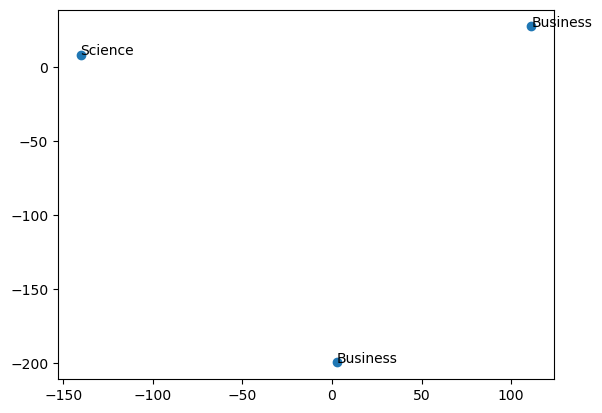

In [24]:
# Scatter plot
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Annotate with topics
topics = [article['topic'] for article in articles]
for i, topic in enumerate(topics):
    plt.annotate(topic, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

## Measuring similarity among text

In [33]:
from scipy.spatial import distance

# Example: Comparing a search query to articles
search_text = "Renewable energy breakthrough"
search_embedding = client.embeddings.create(
    model="text-embedding-3-small",
    input=search_text
).model_dump()['data'][0]['embedding']

# Calculate distances between the search query and each article
distances = [distance.cosine(search_embedding, article["embedding"]) for article in articles]
print(f"distances between search query and articles: {distances}")

# Find the most similar article
closest_index = np.argmin(distances)
print(f"\nSearch query: {search_text}")
print(f"Closest article: {articles[closest_index]['headline']} -> distance: {distances[closest_index]:.2f}")

distances between search query and articles: [0.7707682350438283, 0.8032045192341671, 0.22843681002691207]

Search query: Renewable energy breakthrough
Closest article: Scientists Make Breakthrough Discovery in Renewable Energy -> distance: 0.23


# 2. Application of embedding to search

## Create embeddings

In [37]:
def create_embeddings(texts):
    response = client.embeddings.create(model="text-embedding-3-small",
                                        input=texts)

    return [data['embedding'] for data in response.model_dump()['data']]

# Example data
articles = [
    {"headline": "Tech Giant Buys 49% Stake in AI Startup", "topic": "Tech"},
    {"headline": "Economic Growth Continues Amid Global Uncertainty", "topic": "Business"}]

article_embedding = create_embeddings([article['headline'] for article in articles])

## Compute cosine distances

In [38]:
query_text = "AI-powered startups"
query_embedding = create_embeddings([query_text])[0]

def find_closest(query_vector, embeddings, n=3):
    distances = [{'distance': distance.cosine(query_vector, embedding), 'index': i} for i, embedding in enumerate(embeddings)]

    return sorted(distances, key=lambda x: x['distance'])[:n]

# Find closest article
closest_articles = find_closest(query_embedding, article_embedding)
for match in closest_articles:
    print(f"Article: {articles[match['index']]['headline']} -> distance: {match['distance']:.2f}")

Article: Tech Giant Buys 49% Stake in AI Startup -> distance: 0.43
Article: Economic Growth Continues Amid Global Uncertainty -> distance: 0.83


## Enriched Embeddings for Better Context

The intention here is not clearly stated.So, keep the principles of embeddings in mind

In [39]:
articles = [
    {"headline": "Tech Giant Buys 49% Stake in AI Startup",
     "topic": "Tech",
     "keywords": ["AI", "business", "startup"]}]

def create_article_text(article):
    return f"""Headline: {article['headline']}\nTopic: {article['topic']}\nKeywords: {', '.join(article['keywords'])}"""

article_texts = [create_article_text(article) for article in articles]

In [40]:
article_embeddings = create_embeddings(article_texts)

In [43]:
# Example for user history
user_history = [{"headline": "Tech Giant Buys 49% Stake in AI Startup", "topic": "Tech", "keywords": ["AI", "business"]}]

history_texts = [create_article_text(article) for article in user_history]
history_embeddings = create_embeddings(history_texts)

In [44]:
# Combine History into a Single Vector
mean_history_embedding = np.mean(history_embeddings, axis=0)

In [45]:
# Find similar articles
articles_filtered = [article for article in articles if article not in user_history]
article_texts_filtered = [create_article_text(article) for article in articles_filtered]
article_embeddings_filtered = create_embeddings(article_texts_filtered)

recommendations = find_closest(mean_history_embedding, article_embeddings_filtered)
for rec in recommendations:
    print(articles_filtered[rec['index']]['headline'])

Tech Giant Buys 49% Stake in AI Startup


In [47]:
# Define class descriptions
classes = [
    {"label": "Tech", "description": "A news article about technology"},
    {"label": "Business", "description": "A news article about business"}]

class_texts = [cls['description'] for cls in classes]
class_embeddings = create_embeddings(class_texts)

# Embed an article
article = {"headline": "Tech Giant Buys 49% Stake in AI Startup", "keywords": ["AI", "business"], "topic": "Tech"}
article_text = create_article_text(article)
article_embedding = create_embeddings([article_text])[0]

# Find the closest class
closest_class = find_closest(article_embedding, class_embeddings)[0]
print(classes[closest_class['index']]['label'])

Tech


# Vector database

In [48]:
import chromadb

client = chromadb.PersistentClient(path='./chroma_db')

In [49]:
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

collection = client.create_collection(name='my_collection',
                                      embedding_function=OpenAIEmbeddingFunction(model_name='text-embedding-3-small',
                                                                                 api_key=api_key))

In [50]:
# Inspect collection in the db
print(client.list_collections())

[Collection(name=my_collection)]


## Adding Embeddings to a Collection

In [51]:
# Adding a single document
collection.add(ids=['doc1'],
               documents=['This is a sample document.'])

# Adding multiple document
collection.add(ids=['doc2', 'doc3'],
               documents=['This is another sample document.', 'This is the third sample document.'])

In [52]:
# Count the number of documents in the db
print(collection.count())

# Peek at the first items
print(collection.peek())

3
{'ids': ['doc1', 'doc2', 'doc3'], 'embeddings': array([[ 0.0179235 ,  0.05121784,  0.02744793, ...,  0.00250805,
        -0.03697237,  0.00571603],
       [ 0.01769774,  0.03653013,  0.00687707, ...,  0.00632013,
        -0.01941355,  0.00677675],
       [ 0.00018004,  0.0467242 ,  0.02969595, ...,  0.01414421,
        -0.01095659,  0.03099307]]), 'documents': ['This is a sample document.', 'This is another sample document.', 'This is the third sample document.'], 'uris': None, 'included': ['metadatas', 'documents', 'embeddings'], 'data': None, 'metadatas': [None, None, None]}


## Querying data

In [53]:
result = collection.query(query_texts=['sample query text'],
                          n_results=3)
print(result)

{'ids': [['doc1', 'doc2', 'doc3']], 'embeddings': None, 'documents': [['This is a sample document.', 'This is another sample document.', 'This is the third sample document.']], 'uris': None, 'included': ['metadatas', 'documents', 'distances'], 'data': None, 'metadatas': [[None, None, None]], 'distances': [[1.0307526588439941, 1.131938099861145, 1.1829676628112793]]}


In [54]:
# Updating existing documents
collection.update(ids=['doc1'],
                  documents=['Updated document content.'])

# Upsert documents: If the ID exists, it updates; otherwise, it adds
collection.upsert(ids=['doc4'],
                  documents=['New document content.'])

# Deleting data
collection.delete(ids=['doc1'])

In [55]:
print(collection.peek())

{'ids': ['doc2', 'doc3', 'doc4'], 'embeddings': array([[ 0.01769774,  0.03653013,  0.00687707, ...,  0.00632013,
        -0.01941355,  0.00677675],
       [ 0.00018004,  0.0467242 ,  0.02969595, ...,  0.01414421,
        -0.01095659,  0.03099307],
       [-0.01206921,  0.0537861 , -0.00711374, ..., -0.00269605,
        -0.02440821,  0.0092862 ]]), 'documents': ['This is another sample document.', 'This is the third sample document.', 'New document content.'], 'uris': None, 'included': ['metadatas', 'documents', 'embeddings'], 'data': None, 'metadatas': [None, None, None]}


In [56]:
# Adding metadata
collection.add(ids=['doc5'],
               documents=['Metadata example document.'],
               metadatas=[{'type': 'example', 'release_year': 2023}])

In [57]:
print(collection.peek())

{'ids': ['doc2', 'doc3', 'doc4', 'doc5'], 'embeddings': array([[ 0.01769774,  0.03653013,  0.00687707, ...,  0.00632013,
        -0.01941355,  0.00677675],
       [ 0.00018004,  0.0467242 ,  0.02969595, ...,  0.01414421,
        -0.01095659,  0.03099307],
       [-0.01206921,  0.0537861 , -0.00711374, ..., -0.00269605,
        -0.02440821,  0.0092862 ],
       [-0.02259407,  0.05222908,  0.01396366, ..., -0.02805868,
         0.00625934, -0.00640056]]), 'documents': ['This is another sample document.', 'This is the third sample document.', 'New document content.', 'Metadata example document.'], 'uris': None, 'included': ['metadatas', 'documents', 'embeddings'], 'data': None, 'metadatas': [None, None, None, {'release_year': 2023, 'type': 'example'}]}


In [60]:
# Filtering results using advanced queries: The filtering is done using the metadata fields
# Filters support operators like $eq, $ne, $gt, $gte, $lt, $lte, $and, and $or.
result =  collection.query(query_texts=['example query'],
                           n_results=3,
                           where={'$and':[
                                         {'type': {'$eq': 'example'}},
                                         {'release_year': {'$gt': 2020}}]})
print(result)

{'ids': [['doc5']], 'embeddings': None, 'documents': [['Metadata example document.']], 'uris': None, 'included': ['metadatas', 'documents', 'distances'], 'data': None, 'metadatas': [[{'type': 'example', 'release_year': 2023}]], 'distances': [[1.4453833103179932]]}


# Estimating costs

In [61]:
import tiktoken

enc = tiktoken.encoding_for_model("text-embedding-3-small")
total_tokens = sum(len(enc.encode(text['headline'])) for text in articles)
cost_per_1k_tokens = 0.00002

print('Total tokens:', total_tokens)
print('Cost:', cost_per_1k_tokens * total_tokens / 1000)

Total tokens: 11
Cost: 2.2e-07
